In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.stats as stats
import scipy.ndimage as ndimage

In [2]:
df = pd.read_csv("rec.txt", header = 4, index_col=False)

df = df[[f' EXG Channel {i}' for i in range(8)] + [' Other.2']]
channel_names = ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'photoresistor']
df.columns = channel_names
df[['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']] *= 1e-6
df = df.T

In [3]:
info = mne.create_info(channel_names, 250, ch_types=["eeg"]*8 + ['stim'])
raw = mne.io.RawArray(df, info);

Creating RawArray with float64 data, n_channels=9, n_times=60214
    Range : 0 ... 60213 =      0.000 ...   240.852 secs
Ready.


In [4]:
events = mne.find_events(raw, stim_channel="photoresistor")
mapping = {
    1: "flash",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)
raw.set_annotations(annot_from_events);

95 events found on stim channel photoresistor
Event IDs: [1]


Using matplotlib as 2D backend.


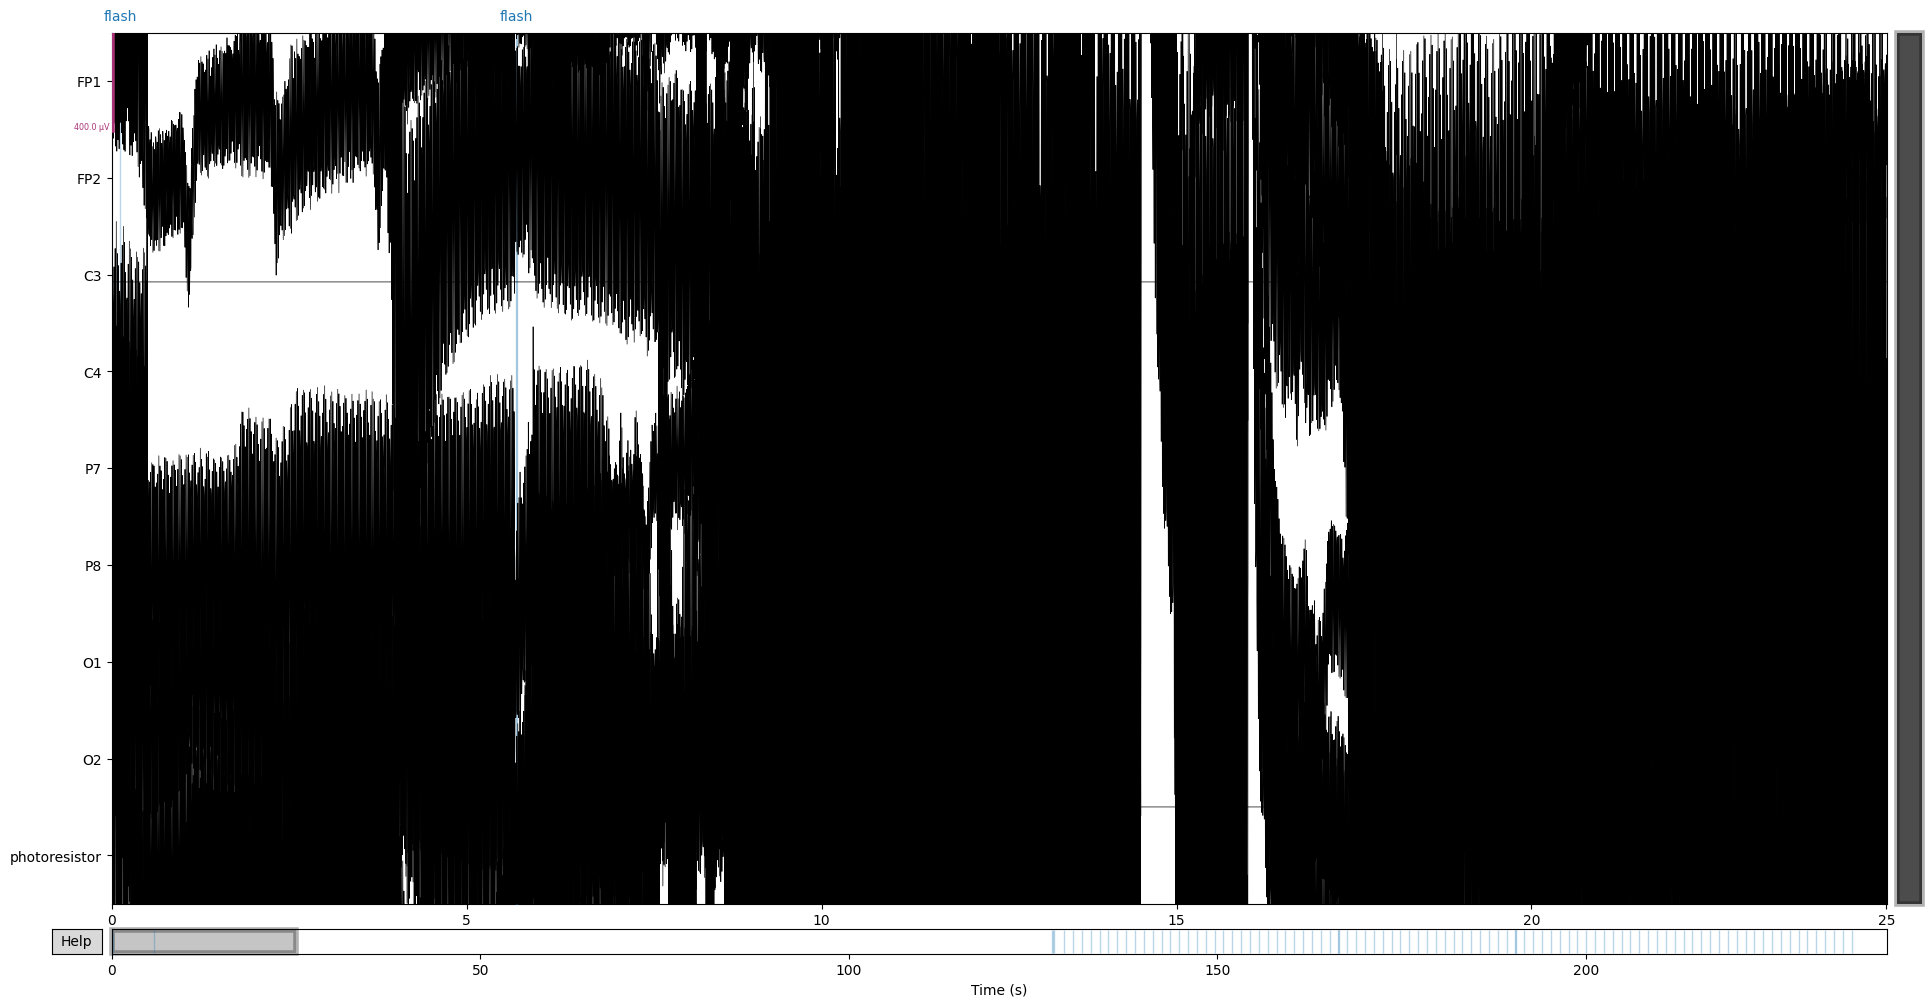

In [5]:
raw.plot(duration=25, scalings=dict(eeg=200e-6), clipping=None);

In [6]:
raw.notch_filter(60)
raw.filter(1,50)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"8 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [7]:
events[:10], events[-5:]

(array([[   29,     0,     1],
        [ 1425,     0,     1],
        [31912,     0,     1],
        [31936,     0,     1],
        [31960,     0,     1],
        [32311,     0,     1],
        [32611,     0,     1],
        [32911,     0,     1],
        [33211,     0,     1],
        [33512,     0,     1]], dtype=int64),
 array([[57825,     0,     1],
        [58125,     0,     1],
        [58426,     0,     1],
        [58726,     0,     1],
        [59026,     0,     1]], dtype=int64))

In [8]:
stimulate_start = events[4][0]/250+0.5
stimulate_end = events[-1][0]/250+1.0

In [9]:
# stimulate_start = events[5][0]/250+0.5
# stimulate_end = events[-2][0]/250+1.0

In [10]:
raw.crop(tmin=stimulate_start, tmax=stimulate_end);

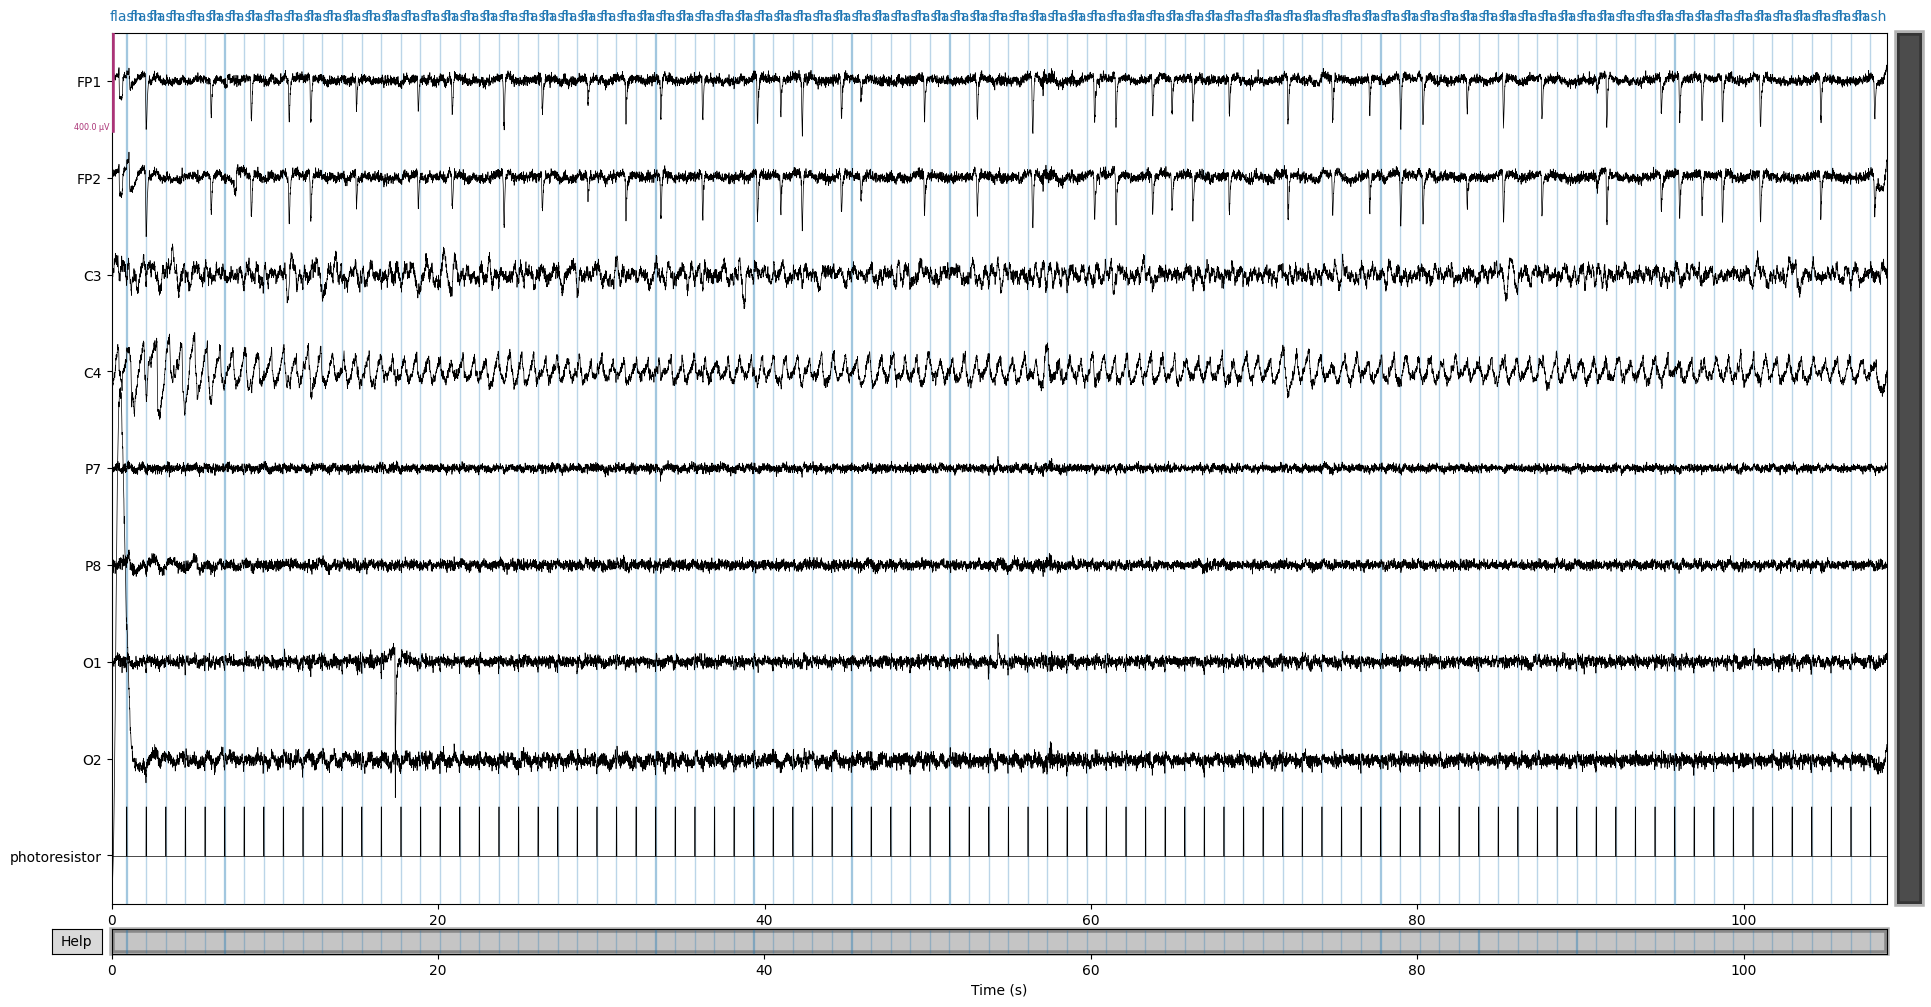

In [11]:
raw.plot(duration=200, scalings=dict(eeg=200e-6), clipping=None);

In [12]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events=events_from_annot)
epochs_data = epochs.get_data()
epochs_data.shape

Used Annotations descriptions: ['flash']
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 176 original time points ...
0 bad epochs dropped


(90, 9, 176)

In [13]:
epochs.load_data()
baseline_epochs = epochs.copy().crop(tmin=-0.2, tmax=0.0)
baseline_data = baseline_epochs.get_data()
baseline_data.shape

Using data from preloaded Raw for 90 events and 176 original time points ...


C:\Users\yuans\AppData\Local\Temp\ipykernel_19756\1002854038.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  baseline_data = baseline_epochs.get_data()


(90, 9, 51)

In [14]:
baseline_mean = baseline_data.mean(axis=2, keepdims=True)
baseline_std = baseline_data.std(axis=2, keepdims=True)
epochs_data = (epochs_data - baseline_mean) / baseline_std

In [15]:
mask = pd.read_csv('circle_mask.csv', header=None).values.flatten()
mask.shape
circles_array = epochs_data[mask == 1][:, :8, :]
squares_array = epochs_data[mask == 0][:, :8, :]
print("circles array",circles_array.shape)
print("square array",squares_array.shape)

circles array (15, 8, 176)
square array (75, 8, 176)


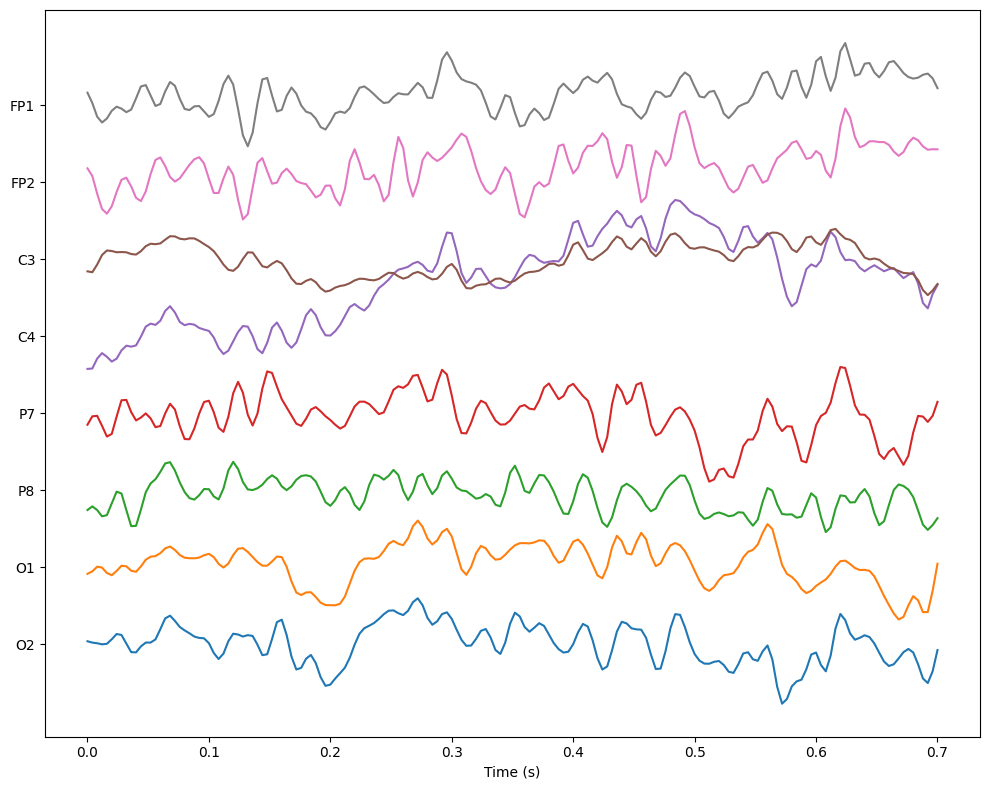

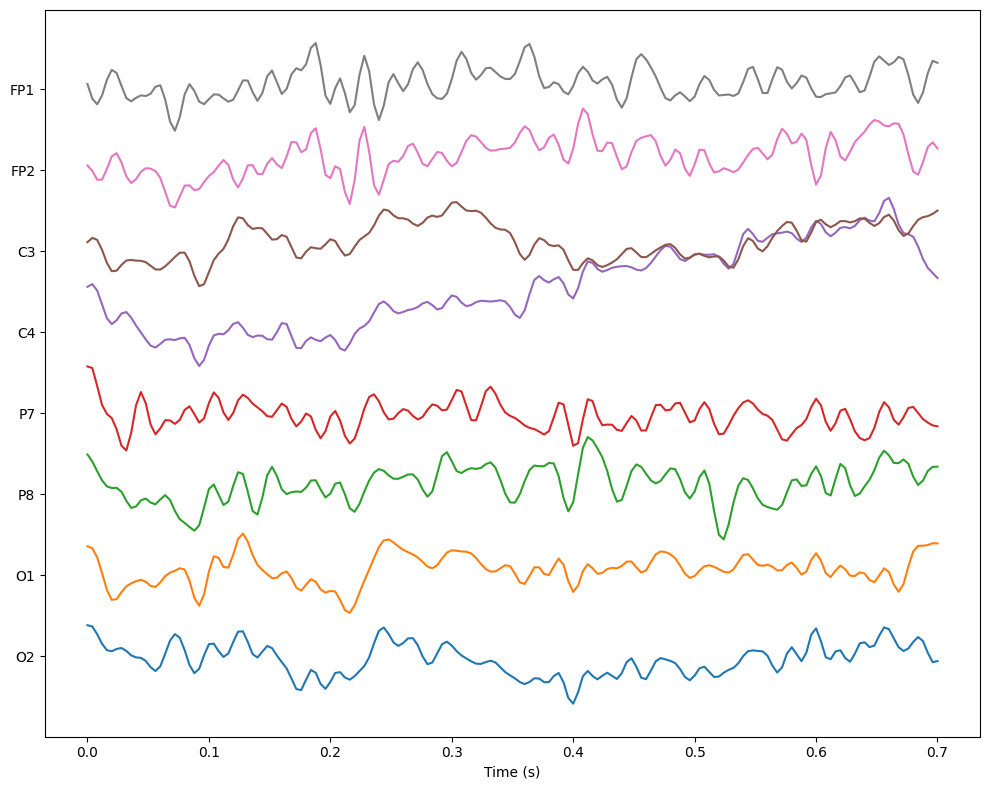

In [23]:
# plot function
def plot(data_array):
    times = np.arange(data_array.shape[1]) / 250

    plt.figure(figsize=(10, 8))
    n_channels = data_array.shape[0]

    for ch in range(n_channels):
        plt.plot(times, data_array[::-1][ch] + ch * 5)

    plt.xlabel('Time (s)')
    plt.yticks(ticks=np.arange(n_channels) * 5, labels=channel_names[:-1][::-1])
    plt.tight_layout()
    plt.show()

plot(circles_array[11])
plot(squares_array[11])

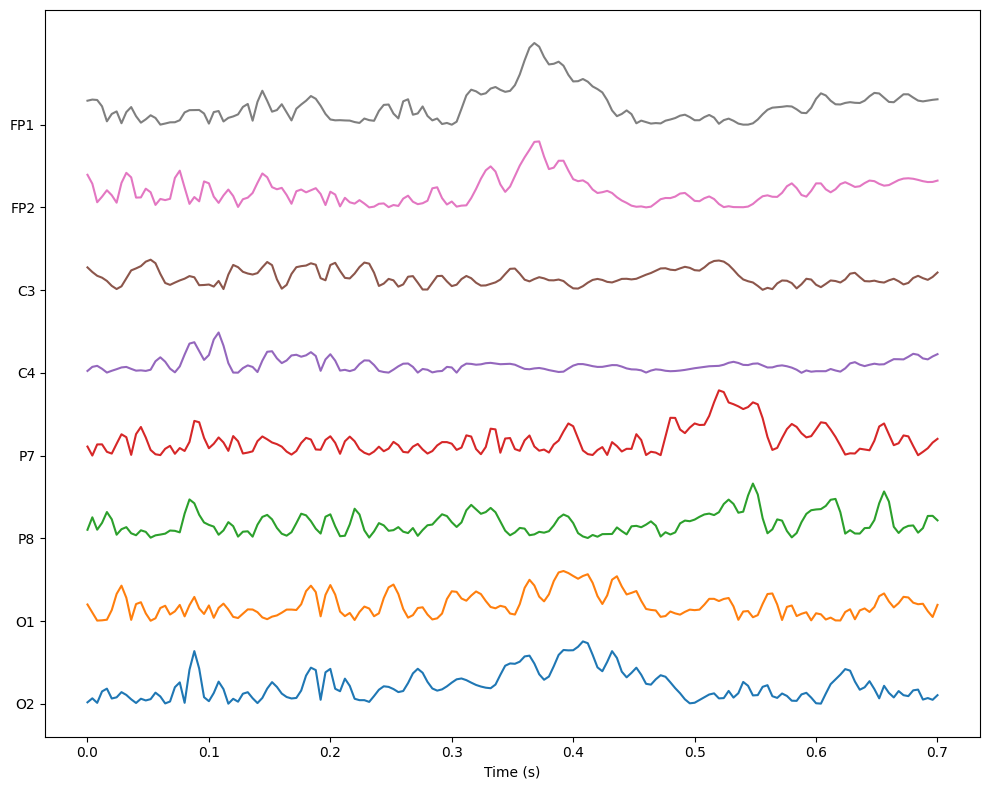

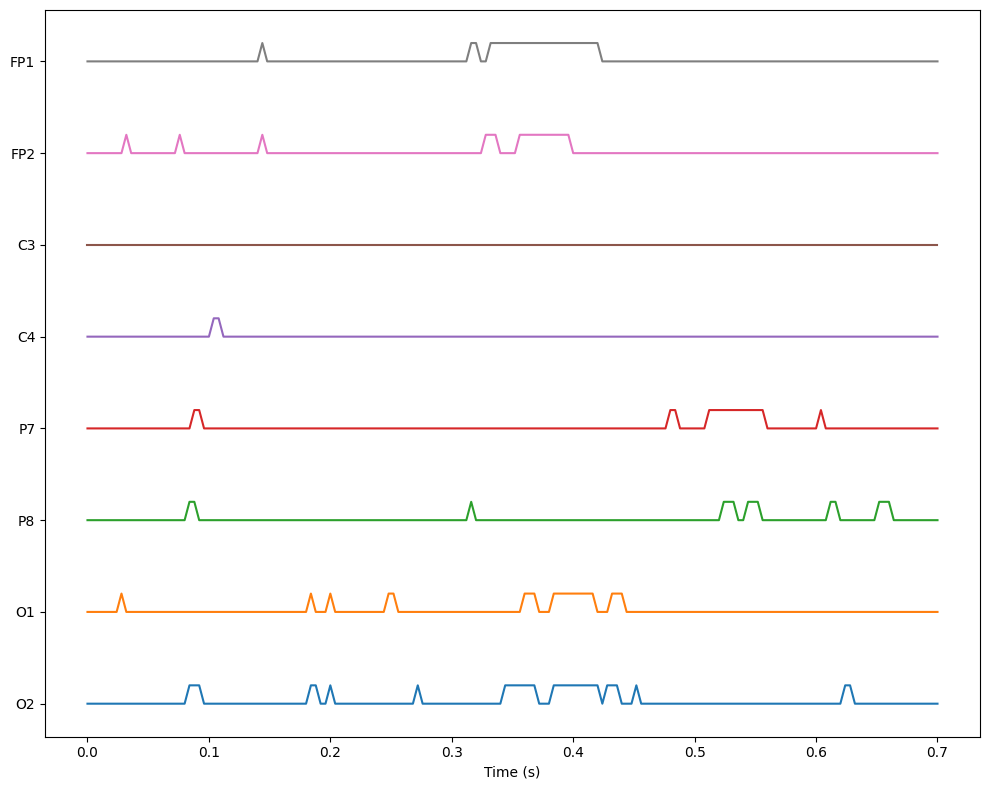

In [17]:
t_stats, p_values = stats.ttest_ind(circles_array, squares_array)
sig_p_values = p_values < 0.05
plot(np.abs(t_stats))
plot(sig_p_values)

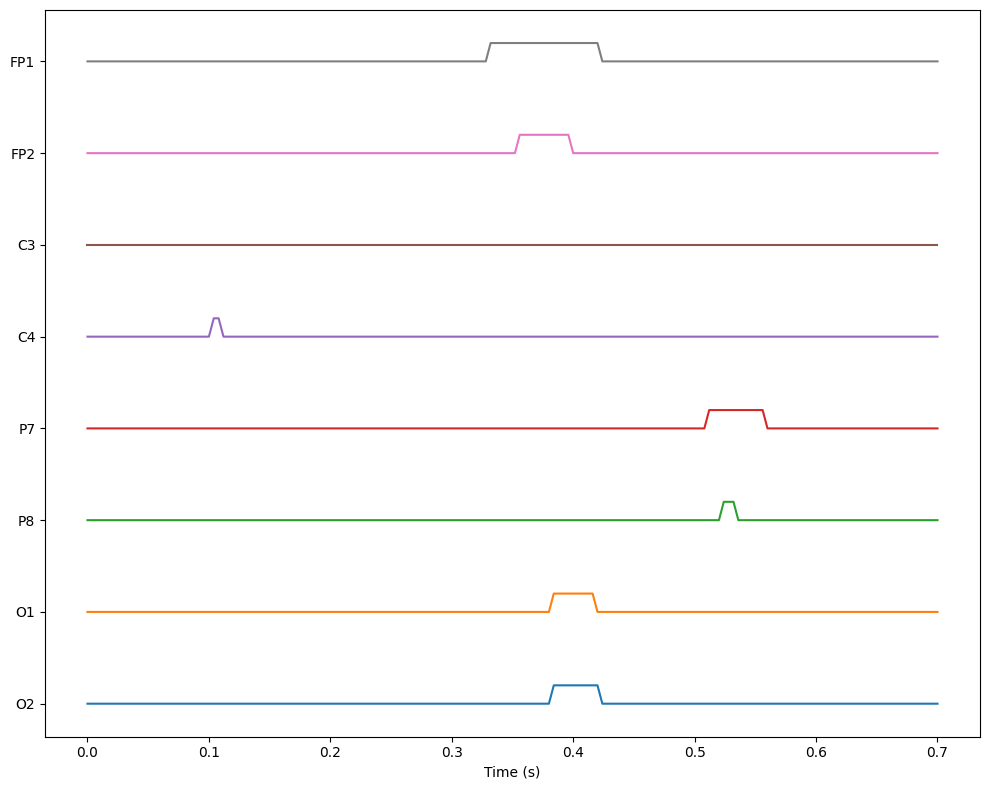

In [18]:
cluster_locations = []
for k, channel_p_vals in enumerate(sig_p_values):
    clusters, num_clusters = ndimage.label(channel_p_vals)
    max_cluster_size = 0
    max_cluster_label = None
    for i in range(1, num_clusters + 1):
        cluster_size = np.sum(clusters == i)
        if cluster_size > max_cluster_size:
            max_cluster_size = cluster_size
            max_cluster_label = i
    if max_cluster_label:
        cluster_locations.append(clusters == max_cluster_label)
    else:
        cluster_locations.append(np.zeros_like(clusters))
cluster_locations = np.array(cluster_locations)
new_sig_p_values = np.copy(sig_p_values)
for i in range(len(new_sig_p_values)):
    new_sig_p_values[i] = new_sig_p_values[i] * cluster_locations[i]
plot(new_sig_p_values)

In [19]:
def single_test(dataset_a, dataset_b):
    t_stats, p_values = stats.ttest_ind(dataset_a, dataset_b)
    t_stats = np.abs(t_stats)
    sig_p_values = p_values < 0.05
    clus_tstat = []
    for k, channel_p_vals in enumerate(sig_p_values):
        clusters, num_clusters = ndimage.label(channel_p_vals)
        max_cluster_size = 0
        max_cluster_label = None
        for i in range(1, num_clusters + 1):
            cluster_size = np.sum(clusters == i)
            if cluster_size > max_cluster_size:
                max_cluster_size = cluster_size
                max_cluster_label = i
        if max_cluster_label:
            largest_cluster_indices = np.where(clusters == max_cluster_label)[0]
            clus_tstat.append(np.sum(t_stats[k][largest_cluster_indices]))
        else:
            clus_tstat.append(0)
    return np.array(clus_tstat)

single_test(circles_array, squares_array)

array([71.14524665, 32.67792665,  0.        ,  4.45816464, 37.01702678,
        6.49059886, 24.403684  , 30.94423345])

In [20]:
def nonparametric_test(dataset_a, dataset_b, n_perm=1000):
    real_cluster_stats = single_test(dataset_a, dataset_b)
    random_higher_count = np.zeros((len(real_cluster_stats),))
    combined_data = np.concatenate([dataset_a, dataset_b], axis=0)

    for i in range(n_perm):
        np.random.shuffle(combined_data)
        perm_a = combined_data[:dataset_a.shape[0]]
        perm_b = combined_data[dataset_a.shape[0]:]

        random_cluster_stats = single_test(perm_a, perm_b)
        random_higher_count += random_cluster_stats > real_cluster_stats

    random_higher_count /= n_perm
    return random_higher_count

nonparametric_p_values = nonparametric_test(circles_array, squares_array)
print(nonparametric_p_values)

[0.01  0.079 0.787 0.455 0.002 0.519 0.014 0.018]


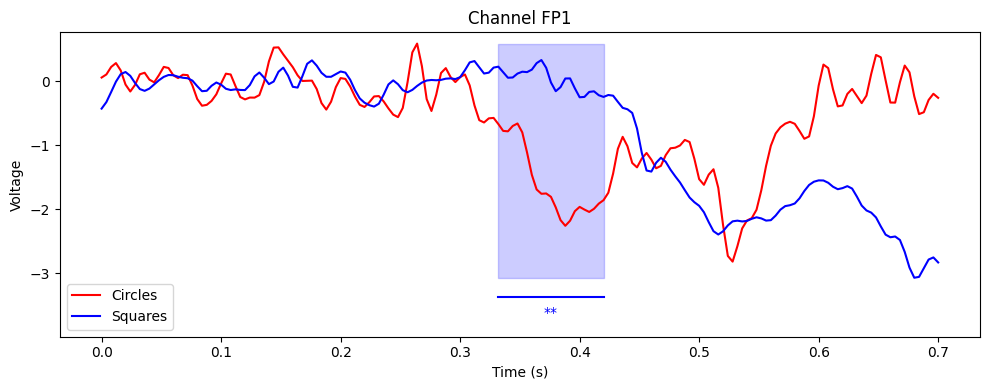

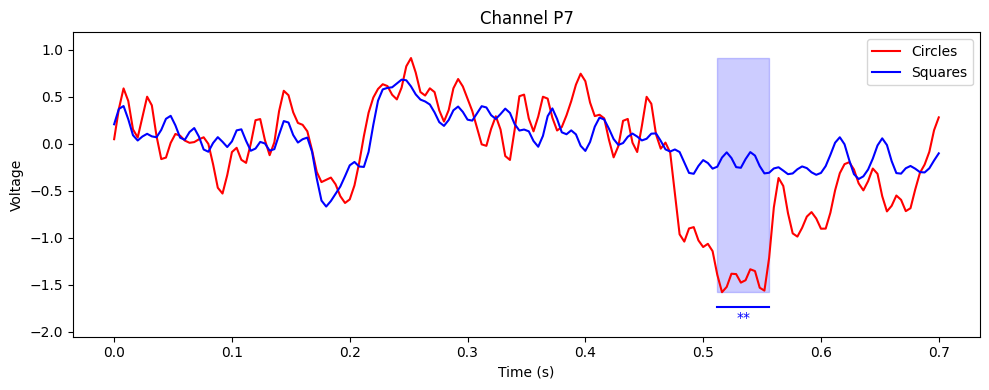

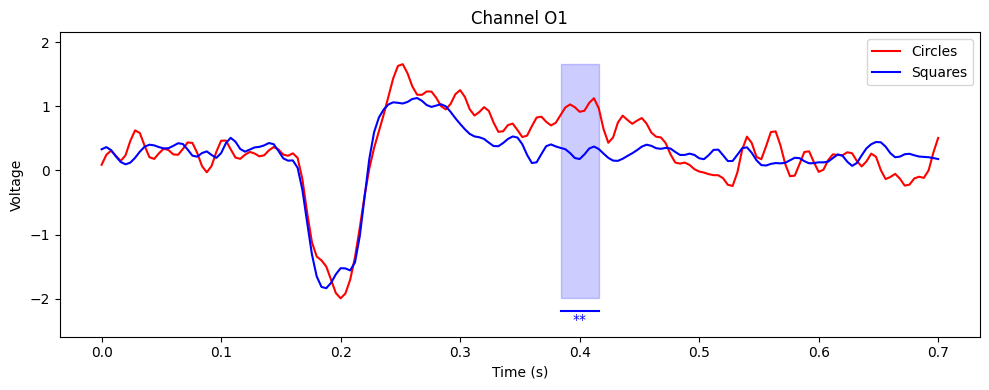

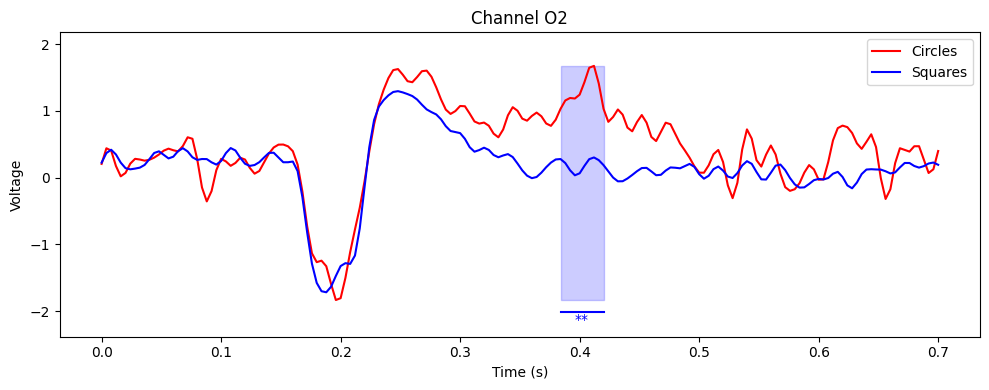

In [25]:
for i in range(len(nonparametric_p_values)):
    if nonparametric_p_values[i] < 0.05:
        x = np.arange(circles_array.shape[2]) / 250
        circles = np.mean(circles_array[:,i,:], axis = 0)
        squares = np.mean(squares_array[:,i,:], axis = 0)
        mini = np.concatenate((circles, squares)).min()
        maxi = np.concatenate((circles, squares)).max()
        mask = cluster_locations[i]
        masked_time = np.extract(mask, x)

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(x, circles, color='red', label='Circles')
        ax.plot(x, squares, color='blue', label='Squares')
        ax.fill_between(x, mini, maxi, where=mask, color='blue', alpha=0.2)
        ax.plot(masked_time, np.full(masked_time.shape, mini*1.1), color='blue')
        ax.text(masked_time.mean(), mini*1.2, '**', ha='center', color='blue')
        ax.set_ylim([mini*1.3, maxi*1.3])

        ax.set_title(f"Channel {channel_names[i]}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage")
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()